Epoch [1/10], Step [10/469], Loss: 1.2040
Epoch [1/10], Step [20/469], Loss: 0.8472
Epoch [1/10], Step [30/469], Loss: 0.8485
Epoch [1/10], Step [40/469], Loss: 0.6791
Epoch [1/10], Step [50/469], Loss: 0.4880
Epoch [1/10], Step [60/469], Loss: 0.5880
Epoch [1/10], Step [70/469], Loss: 0.4474
Epoch [1/10], Step [80/469], Loss: 0.4594
Epoch [1/10], Step [90/469], Loss: 0.9275
Epoch [1/10], Step [100/469], Loss: 0.6352
Epoch [1/10], Step [110/469], Loss: 0.5715
Epoch [1/10], Step [120/469], Loss: 0.3797
Epoch [1/10], Step [130/469], Loss: 0.4075
Epoch [1/10], Step [140/469], Loss: 0.4114
Epoch [1/10], Step [150/469], Loss: 0.5897
Epoch [1/10], Step [160/469], Loss: 0.9721
Epoch [1/10], Step [170/469], Loss: 0.5482
Epoch [1/10], Step [180/469], Loss: 0.3715
Epoch [1/10], Step [190/469], Loss: 0.4466
Epoch [1/10], Step [200/469], Loss: 0.4400
Epoch [1/10], Step [210/469], Loss: 0.3882
Epoch [1/10], Step [220/469], Loss: 0.5704
Epoch [1/10], Step [230/469], Loss: 0.4414
Epoch [1/10], Step [

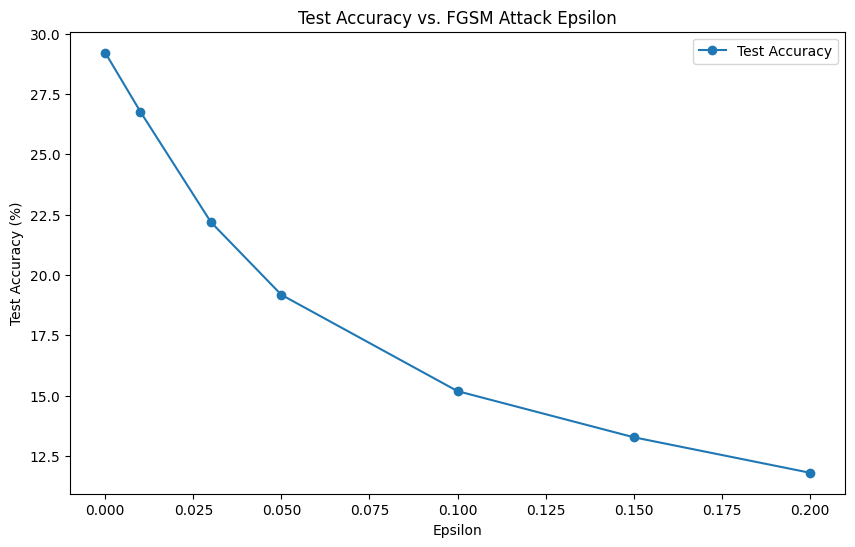

Adversarial Retrain Epoch [1/10], Step [10/469], Loss: 0.4260
Adversarial Retrain Epoch [1/10], Step [20/469], Loss: 0.5568
Adversarial Retrain Epoch [1/10], Step [30/469], Loss: 0.7092
Adversarial Retrain Epoch [1/10], Step [40/469], Loss: 0.4248
Adversarial Retrain Epoch [1/10], Step [50/469], Loss: 0.4834
Adversarial Retrain Epoch [1/10], Step [60/469], Loss: 0.5097
Adversarial Retrain Epoch [1/10], Step [70/469], Loss: 0.3946
Adversarial Retrain Epoch [1/10], Step [80/469], Loss: 0.4642
Adversarial Retrain Epoch [1/10], Step [90/469], Loss: 0.4042
Adversarial Retrain Epoch [1/10], Step [100/469], Loss: 0.3288
Adversarial Retrain Epoch [1/10], Step [110/469], Loss: 0.4855
Adversarial Retrain Epoch [1/10], Step [120/469], Loss: 0.4000
Adversarial Retrain Epoch [1/10], Step [130/469], Loss: 0.3717
Adversarial Retrain Epoch [1/10], Step [140/469], Loss: 0.4618
Adversarial Retrain Epoch [1/10], Step [150/469], Loss: 0.3766
Adversarial Retrain Epoch [1/10], Step [160/469], Loss: 0.3484
A

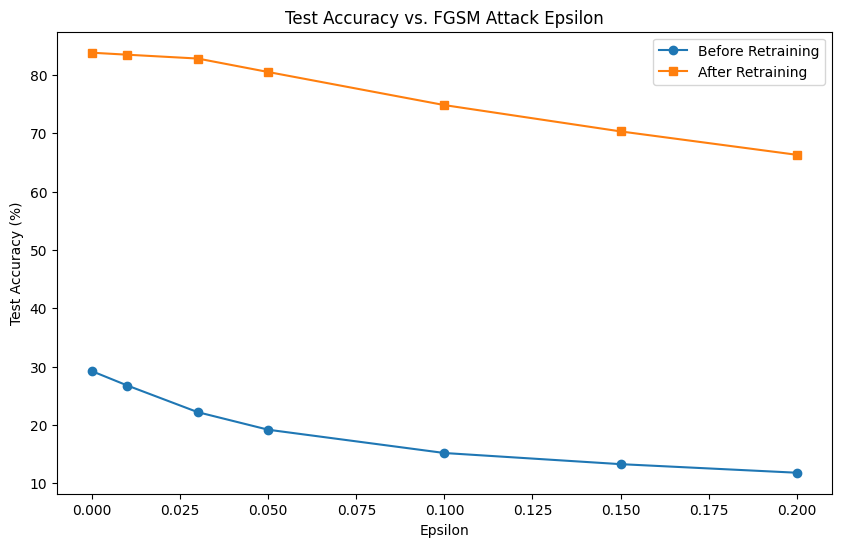

In [1]:
# FGSM Attack and Defend on ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt
from torchvision.models import resnet50

num_epochs = 10
batch_size = 128
learning_rate = 0.001
epsilon_values = [0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_indices = random.sample(range(len(train_dataset)), len(train_dataset))
test_indices = random.sample(range(len(test_dataset)), len(test_dataset))

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False)

model = resnet50(num_classes=10)  
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

def test_model(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f'Accuracy on the clean test set: {test_model(test_loader):.2f}%')


# FGSM Attack
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  
    return perturbed_images

accuracies = []

for epsilon in epsilon_values:
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon:.2f}, Test Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o', label='Test Accuracy')
plt.title('Test Accuracy vs. FGSM Attack Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()


# Defend Method
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon=0.03)

        combined_images = torch.cat([images, adv_images], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Adversarial Retrain Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print(f'Accuracy on the clean test set after adversarial retraining: {test_model(test_loader):.2f}%')

accuracies_after_retrain = []

for epsilon in epsilon_values:
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    accuracies_after_retrain.append(accuracy)
    print(f"Epsilon: {epsilon:.2f}, Test Accuracy after Retraining: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o', label='Before Retraining')
plt.plot(epsilon_values, accuracies_after_retrain, marker='s', label='After Retraining')
plt.title('Test Accuracy vs. FGSM Attack Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()
